In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import root_scalar
from scipy.integrate import solve_ivp

In [13]:
# constants
M_sun_kg = 1.9891e30 # solar mass in kg
M_sun_g = 1.9891e33 # solar mass in gram
yr2s = 31556926 # year in seconds
G = 6.67430e-11 # Newton gravity constant, m^3/kg/s^2
mp = 1.6726e-27 # proton mass, kg
kB = 1.38064e-23 # Boltzman constant, m^2 kg /s^2 /K
K_2_MeV = 1000 / 1.161e13 # Kelvin to MeV
K_2_erg = 1.3806e-16 # Kelvin to erg
MeV2kg = 1.783e-30 # MeV to kg
light_speed = 29979245800 # cm/s
M_sun_erg = 1.79e54 # solar mass to erg
g2erg = 8.987e20 # 1 gram to erg
cm3_2_perMeV3 = (1/1.973e-11)**3 # cm^3 to 1/MeV^3
kB_MeV = 8.617e-11 # MeV/K
me = 0.511 # electron mass MeV
mH = 938.272 # hydrogen mass MeV, H
mHe = 2808.39 # helium mass MeV, He 4
mH_g = 1.673e-24 # hydrogen mass gram
mHe_g = 6.646e-24 # helium mass gram
MeV_2_erg = 1.602e-6 # MeV to erg
sig_SB = 5.670374419e-5 # erg/cm^2/s/K^4 Stefan Boltzmann constant
a = 4 * sig_SB / light_speed # erg/cm^3/K^4 radiation density constant

In [16]:
# Load CSM data
# In the following we use realistic CSM density from Zimmerman+ Nature 627, 762 (2024)
rho_SN2020tlf_data = np.log10(np.loadtxt('CSM_density/SN2020tlf.txt').T)
rho_SN2023ixf_data = np.log10(np.loadtxt('CSM_density/SN2023ixf.txt').T)
rho_SN2023ixf_sharp_data = np.log10(np.loadtxt('CSM_density/SN2023ixf_sharp.txt').T)
rho_SN2024ggi_data = np.log10(np.loadtxt('CSM_density/SN2024ggi.txt').T)
# Interp in log10 scale
rho_2020tlf_interp = interp1d(rho_SN2020tlf_data[0],rho_SN2020tlf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_interp = interp1d(rho_SN2023ixf_data[0],rho_SN2023ixf_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2023ixf_s_interp = interp1d(rho_SN2023ixf_sharp_data[0],rho_SN2023ixf_sharp_data[1],kind='linear',bounds_error=False,fill_value=np.nan)
rho_2024ggi_interp = interp1d(rho_SN2024ggi_data[0],rho_SN2024ggi_data[1],kind='linear',bounds_error=False,fill_value=np.nan)

# r_max = rho_data[0][-1]
# r_min = rho_data[0][0]

r_mins = {'SN 2020tlf':10**rho_SN2020tlf_data[0,0],'SN 2023ixf':10**rho_SN2023ixf_data[0,0],'SN 2023ixf s':10**rho_SN2023ixf_sharp_data[0,0],'SN 2024ggi':10**rho_SN2024ggi_data[0,0]} 

def CSM_density(r,SN_name='SN 2023ixf'):
    """
    g/cm^3
    """
    r = np.log10(r)
    if SN_name == 'SN 2020tlf':
        return 10**rho_2020tlf_interp(r)
    elif SN_name == 'SN 2023ixf':
        return 10**rho_2023ixf_interp(r)
    elif SN_name == 'SN 2023ixf s':
        return 10**rho_2023ixf_s_interp(r)
    elif SN_name == 'SN 2024ggi':
        return 10**rho_2024ggi_interp(r)
    else:
        raise ValueError('\'SN_name\' must be a \'SN 2020tlf\', \'SN 2023ixf\' or \'SN 2024ggi\'.')

SN_names = ['SN 2020tlf','SN 2023ixf','SN 2024ggi']

In [56]:
M_CSM = 4 * np.pi * quad(lambda r: r**2 * CSM_density(r),4e13,1.9e14)[0] # gram
V_CSM = 4 * np.pi * ((1.9e14)**3 - (4e13)**3) / 3 # cm^3
avg_rho_CSM = M_CSM / V_CSM # g/cm^3

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/1458707786.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  M_CSM = 4 * np.pi * quad(lambda r: r**2 * CSM_density(r),4e13,1.9e14)[0] # gram


### Gas internal energy
The internal energy of gas $A$ at temperature $T$ is
$$
U_A(T) = \sum_{i=1}\frac{3}{2}k_B N_A (1+x_{A,i})T + N_A x_{A,i}E_{A,i}
$$
where $N_A$ is the total number of $A$ particles, $x_{A,i}$ the fraction of gas $A$ at $i$-th ionization state and $E_{A,i}$ the ionization energy at $i$-th state.


Values for quantities with different elements are listed below
|        |  $E_{1}\,{\rm [eV]}$   |$E_{2}\,{\rm [eV]}$   |$G_{1}$  |$G_{2}$  |
|  ----  | ----  |----  |----  |----  |
| H  | 13.6 | 0 | 2 | 0 |
| He  | 24.6 | 54.4| 4 | 1 |

Note that in CSM, hydrogen exists in H and helium in <sup>4</sup>He with mass fractions about 75% and 25% respectively.

### The ionization fraction

Define the Saha constant $K$ at temperature $T$ for element $A$ with ionization level $i$,
$$
K_{A,i}(T)=\frac{n_{A,i+1} n_e}{n_{A,i}}=\left(\frac{m_e k_B T}{2\pi \hbar^2}\right)^{3/2}\frac{2Z_{A,i+1}}{Z_{A,i}}e^{-\chi_A/k_B T}
$$
where $Z_{A,i}$ and $\chi_{A,i}$ are the associate partition function and ionization energy respectively.

In terms of hydrogen and helium, we have
\begin{alignat}{1}
K_{\rm H}(T) &= \frac{n_{\rm H^+} n_e}{n_{\rm H^0}}=\left(\frac{m_e k_B T}{2\pi \hbar^2}\right)^{3/2}\frac{2Z_{\rm H^+}}{Z_{\rm H^0}}e^{-\chi_{\rm H}/k_B T}, \\
K_{\rm He^+}(T) &= \frac{n_{\rm He^+} n_e}{n_{\rm He^0}}=\left(\frac{m_e k_B T}{2\pi \hbar^2}\right)^{3/2}\frac{2Z_{\rm He^+}}{Z_{\rm He^0}}e^{-\chi_{\rm He^+}/k_B T}, \\
K_{\rm He^{++}}(T) &= \frac{n_{\rm He^{++}} n_e}{n_{\rm He^+}}=\left(\frac{m_e k_B T}{2\pi \hbar^2}\right)^{3/2}\frac{2Z_{\rm He^{++}}}{Z_{\rm He^+}}e^{-\chi_{\rm He^{++}}/k_B T}.
\end{alignat}
The ionization energies are $\chi_{\rm H}=13.6~{\rm eV}$, $\chi_{\rm He^+}=24.6~{\rm eV}$ and $\chi_{\rm He^{++}}=54.4~{\rm eV}$. The partition functions are $Z_{\rm H^0}=2$, $Z_{\rm H^+}=1$, $Z_{\rm He^0}=1$, $Z_{\rm He^+}=2$ and $Z_{\rm He^{++}}=1$.

Because of charge neutrality,
$$
n_e = Z_{\rm H^+} n_{\rm H^+} +Z_{\rm He^+}n_{\rm He^+} + Z_{\rm He^{++}} n_{\rm He^{++}}=  n_{\rm H^+} +n_{\rm He^+} + 2 n_{\rm He^{++}}.
$$
Let the densities of hydrogen and helium are $n_{\rm H}$ and $n_{\rm He}$ respectively, we have the following
\begin{alignat}{1}
n_{\rm H^+} &= n_{\rm H}\left( \frac{K_{\rm H}}{n_e + K_{\rm H}} \right)\\
n_{\rm He^+} &= n_{\rm He}\left( \frac{K_{\rm He^{+}}n_e}{n_e^2 + K_{\rm He^{+}}n_e+ K_{\rm He^{+}} K_{\rm He^{++}}} \right)\\
n_{\rm He^{++}} &= n_{\rm He}\left( \frac{K_{\rm He^{+}}K_{\rm He^{++}}}{n_e^2 + K_{\rm He^{+}}n_e+ K_{\rm He^{+}} K_{\rm He^{++}}} \right)
\end{alignat}
such that
$$
n_e = n_{\rm H}\left( \frac{K_{\rm H}}{n_e + K_{\rm H}} \right) + n_{\rm He}\left( \frac{K_{\rm He^{+}}n_e + 2K_{\rm He^{+}}K_{\rm He^{++}}}{n_e^2 + K_{\rm He^{+}}n_e+ K_{\rm He^{+}} K_{\rm He^{++}}} \right)
$$
which can be solved for $n_e$ iteratively.

### Nucleus number density
For a density of gas $\rho$, with mass ratio $X$ for element $A$ and $Y$ for element $B$, the corresponding number density for these two elements are
$$
n_A = X\frac{\rho}{m_A},\quad{\rm and}\quad n_B = Y\frac{\rho}{m_B}
$$
with the constraint $X+Y=1$.

### The total internal energy

The total internal energy density is the sum of kinetic energy density and ionization energy density at temperature $T$ is 
$$
\frac{dQ(T)}{dV}=\frac{3}{2}[n+n_e(T)]k_B T + \sum_{A,i} n_{A,i}(T) \chi_{A,i} + aT^4
$$
where $n=n_A+n_B$ and $a=8\pi^5 k_B^4/15c^3 h^3 \approx 7.5657\times 10^{-15}~{\rm erg~cm^{-3}~K^{-4}}$ the radiation density constant. To get the total internal energy, we can perform $Q=\int dV\frac{dQ}{dV}$. The heat capacity is thus
$$
c_V = \frac{dQ}{dT} = \frac{3}{2}[N + N_e(T)]k_B + \left(\frac{3}{2}k_B \frac{dN_e}{dT} + \sum_{A,i}\chi_{A,i}\frac{dN_{A,i}}{dT} \right) + 4a T^3
$$
where $N=\int n dV$.

In [50]:
# Physical Constants (cgs)
ME = 9.109e-28       # g
KB = 1.3806e-16      # erg/K
HBAR = 1.0545e-27    # erg*s
EV_TO_ERG = 1.60218e-12

def get_Saha_K(T, chi_ev, Z_low, Z_high):
    """Saha constant K_A,i(T) based on image formula."""
    therm_lambda_factor = (ME * KB * T / (2 * np.pi * HBAR**2))**1.5
    exp_factor = np.exp(-(chi_ev * EV_TO_ERG) / (KB * T))
    return therm_lambda_factor * (2 * Z_high / Z_low) * exp_factor

def get_n_total(T, rho):
    elements = {
        'H':  {'m': 1.67e-24, 'X': 0.75, 'chis': [13.598], 'Zs': [2, 1]},
        'He': {'m': 6.64e-24, 'X': 0.24, 'chis': [24.587, 54.417], 'Zs': [1, 2, 1]},
        'C':  {'m': 1.99e-23, 'X': 0.003, 'chis': [11.26, 24.38, 47.89], 'Zs': [1, 1, 1, 1]},
        'N':  {'m': 2.32e-23, 'X': 0.001, 'chis': [14.53, 29.60, 47.45], 'Zs': [1, 1, 1, 1]},
        'O':  {'m': 2.65e-23, 'X': 0.003, 'chis': [13.62, 35.12, 54.93], 'Zs': [1, 1, 1, 1]},
        'Fe': {'m': 9.27e-23, 'X': 0.001, 'chis': [7.90, 16.19, 30.65],  'Zs': [1, 1, 1, 1]}
    }
    
    n_A = {name: (data['X'] * rho / data['m']) for name, data in elements.items()}
    K_map = {name: [get_Saha_K(T, chi, data['Zs'][i], data['Zs'][i+1]) 
                    for i, chi in enumerate(data['chis'])] for name, data in elements.items()}

    # Newton-Raphson for n_e
    ne = 0.5 * n_A['H'] # Initial guess
    for _ in range(15):
        f = ne
        df_dne = 1.0
        
        for name, K_list in K_map.items():
            Z = len(K_list)
            # terms[k] = (K0*K1...K_{k-1}) * ne^(Z-k)
            terms = [ne**Z]
            for k in range(Z):
                terms.append(terms[-1] * K_list[k] / ne)
            
            denom = sum(terms)
            # electron contribution n_e,A = n_A * sum(k * term_k) / denom
            num_e = sum(k * terms[k] for k in range(1, Z + 1))
            
            # Derivatives for Newton step
            d_terms = [Z * ne**(Z-1) if Z > 0 else 0]
            for k in range(1, Z + 1):
                d_terms.append( (Z-k) * terms[k] / ne if ne != 0 else 0 )
            
            d_num_e = sum(k * d_terms[k] for k in range(1, Z + 1))
            d_denom = sum(d_terms)
            
            f -= n_A[name] * (num_e / denom)
            df_dne -= n_A[name] * (d_num_e * denom - num_e * d_denom) / (denom**2)
            
        ne = ne - f / df_dne
        
    return ne, n_A, K_map


def get_u_gas(T, rho):
    # Unpack all three outputs from get_n_total
    ne, n_A, K_map = get_n_total(T, rho)
    
    # 1. Kinetic Energy
    n_nuclei = sum(n_A.values())
    u_kinetic = 1.5 * (n_nuclei + ne) * KB * T
    
    # 2. Ionization Energy
    u_ionization = 0.0
    for name, K_list in K_map.items():
        Z = len(K_list)
        # Using the same polynomial logic as get_n_total
        terms = [ne**Z]
        for k in range(Z):
            terms.append(terms[-1] * K_list[k] / ne)
            
        denom = sum(terms)
        n_A_neutral = n_A[name] / denom
        
        # Get ionization potentials for this element
        # chis: [chi_0_to_1, chi_1_to_2, ...]
        chis = [13.598, 24.587, 54.417] # Simplified lookup logic
        # For actual code, pull from the elements dict used in get_n_total
        
        cumul_chi = 0.0
        for k in range(1, Z + 1):
            # Energy to reach stage k from neutral (sum of potentials)
            # This is derived from the "chis" list for that specific element
            # Here we assume chis is retrieved correctly per element
            element_chis = [13.598] if name=='H' else [24.587, 54.417] # etc.
            
            # Sum up potentials to stage k
            cumul_chi = sum(element_chis[:k]) * EV_TO_ERG
            
            # n_A,k = n_A * term_k / denom
            n_Ak = n_A[name] * terms[k] / denom
            u_ionization += n_Ak * cumul_chi
                
    return u_kinetic + u_ionization 
    
def get_u_rad(T):
    """
    erg/cm^3
    """
    u_rad = a * T**4 
    return u_rad

def get_u_tot(T,rho):
    return get_u_gas(T,rho) + get_u_rad(T)

In [87]:
temperature_list = np.logspace(3.3,5,100)
Q_rad = np.array([get_u_rad(T) for T in temperature_list]) * V_CSM # erg
Q_gas = np.array([quad(lambda r: 4*np.pi*r**2*get_u_gas(T,CSM_density(r)),4e13,1.9e14)[0] for T in temperature_list]) # erg
Q_tot = Q_rad + Q_gas # erg

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/3868594724.py:39: RuntimeWarning: invalid value encountered in scalar divide
  terms.append(terms[-1] * K_list[k] / ne)
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/3008382903.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Q_gas = np.array([quad(lambda r: 4*np.pi*r**2*get_u_gas(T,CSM_density(r)),4e13,1.9e14)[0] for T in temperature_list]) # erg


Text(0.5, 1.0, 'SN 2023ixf with $M_{\\rm CSM}=0.03~M_\\odot$')

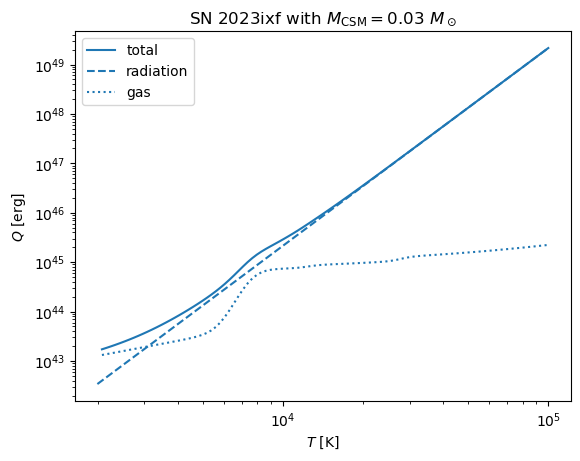

In [93]:
plt.plot(temperature_list,Q_tot,color='C0',label=r'total')
plt.plot(temperature_list,Q_rad,'--',color='C0',label=r'radiation')
plt.plot(temperature_list,Q_gas,':',color='C0',label=r'gas')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$T$ [K]')
plt.ylabel(r'$Q$ [erg]')
plt.legend()
plt.title(fr'SN 2023ixf with $M_{{\rm CSM}}={M_CSM/M_sun_g:.2f}~M_\odot$')
#plt.savefig('Q.png',bbox_inches='tight')

To implement differentiation, we adopt the complex method
$$
\frac{df}{dx} = \frac{{\rm Im}[f(x+ih)]}{h}
$$
with $h$ an extremely small number. With this, we can obtain $dn_i/dT$ easily.

In [160]:
# def get_dn(T,rho,h=1e-8):
#     """
#     dn_nuclei,dne,dnH1,dnHe1,dnHe2  1/cm^3/K
#     """
#     if isinstance(T, (list, np.ndarray)):
#         T = np.array(T).item()
#     return np.imag(get_n(T + 1j * h,rho)) / h


def get_heat_capacity_gas(T,rho,h=1e-8):
    """
    erg/K/cm^3
    """
    T_complex = T + 1j * h
    cv_gas = np.imag(get_u_tot(T_complex,rho)) / h # dU/dT
    return cv_gas

def get_heat_capacity_rad(T):
    """
    erg/K/cm^3
    """
    cv_rad = 4 * a * T**3
    return cv_rad

def get_heat_capacity_tot(T,rho,h=1e-8):
    """
    erg/K/cm^3
    """
    if isinstance(T, (list, np.ndarray)):
        T = np.array(T).item()
    return get_heat_capacity_gas(T,rho,h) + get_heat_capacity_rad(T)

To determine the temperature evolution, we solve
$$
c_V \frac{dT}{dt} = -L_\gamma
$$
where $L_\gamma = 4\pi \sigma_{\rm SB} R_{\rm BB}^2 T^4$ and $R_{\rm BB}$ is the photospheric radius.

The effective surface temperature $T_{\rm sur}$ can be related to the interior temperature $T_{\rm int}$ by the Eddington approximation
$$
T^4_{\rm int} = \frac{3}{4}T_{\rm sur}^4 \left(\tau + \frac{2}{3}\right)
$$
where $\tau$ is the optical depth. Let $T=T_{\rm int}$, we rewrite the evolution equation
$$
c_V \frac{dT}{dt} = -\frac{16\pi \sigma_{\rm SB}R_{\rm BB}^2 T^4}{3}\left(\tau + \frac{2}{3}\right)^{-1}
$$

In [178]:
R_BB = 1.9e14 # cm 
def dTdt(t,T,tau=0):
    Teff4 = T**4 / (tau + 2/3) / (3/4)
    cv = get_heat_capacity_tot(T,avg_rho_CSM,h=1e-8) * V_CSM
    Lg = 4 * np.pi * R_BB**2 * sig_SB * Teff4
    return - Lg/cv

def to_surface_T(T,tau=0):
    """
    Convert interior T to surface T
    """
    return T / ((tau + 2/3) / (3/4))**0.25

In [109]:
def reach_limit(t, T_array,rho):
    # Unpack the scalar (same logic as your dTdt function)
    T = T_array[0]
    
    # The solver stops when this return value is 0
    return T - 3500.0

# Critical: This tells solve_ivp to stop the integration entirely 
# rather than just recording the time it happened.
reach_limit.terminal = True

# Optional: Tells the solver to only trigger if T is decreasing
reach_limit.direction = -1

In [214]:
# --- Simulation Parameters ---
T0 = 13000              # Initial temperature (K)
t_start = 0
t_end = 1e5                 
t_span = (t_start, t_end)
t_eval = np.linspace(t_start,t_end,1000)
tau = 10

# --- Execute the Solver ---
sol_tau_0 = solve_ivp(
    dTdt, 
    t_span, 
    [T0], 
    t_eval = t_eval,
    args=(0,),
    #events=reach_limit,
    #method='Radau', 
    #rtol=1e-5
)

sol_tau = solve_ivp(
    dTdt, 
    t_span, 
    [T0], 
    t_eval = t_eval,
    args=(tau,),
    #events=reach_limit,
    #method='Radau', 
    #rtol=1e-5
)



/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/3868594724.py:54: RuntimeWarning: invalid value encountered in scalar divide
  df_dne -= n_A[name] * (d_num_e * denom - num_e * d_denom) / (denom**2)
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/3868594724.py:11: RuntimeWarning: overflow encountered in exp
  exp_factor = np.exp(-(chi_ev * EV_TO_ERG) / (KB * T))
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/3868594724.py:12: RuntimeWarning: invalid value encountered in scalar multiply
  return therm_lambda_factor * (2 * Z_high / Z_low) * exp_factor
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/3868594724.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  terms.append(terms[-1] * K_list[k] / ne)
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_5911/3868594724.py:39: RuntimeWarning: overflow encountered in scalar multiply
  terms.append(terms[-1] * K_list[k] / ne)
/var/folders/0d/rwlphr1x0sq99

(1200.0, 13570.0)

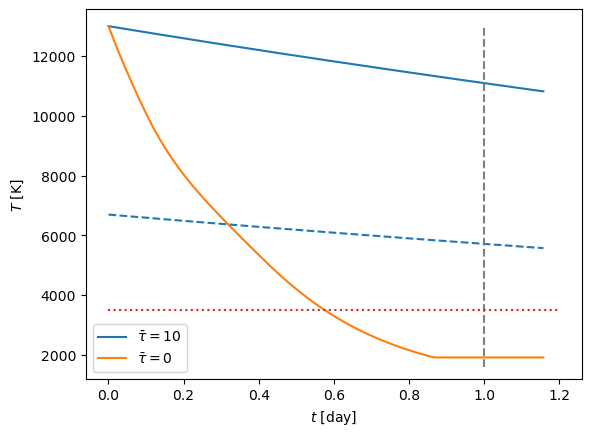

In [216]:
plt.plot(sol_tau.t/24/3600,sol_tau.y[0],label=fr'$\bar{{\tau}}={tau}$',color='C0')
plt.plot(sol_tau.t/24/3600,to_surface_T(sol_tau.y[0],tau),'--',color='C0')
plt.plot(sol_tau_0.t/24/3600,sol_tau_0.y[0],label=r'$\bar{\tau}=0$',color='C1')

plt.plot([1,1],[1600,max(sol_tau_0.y[0])],'--',color='grey')
plt.xlabel(r'$t$ [day]')
plt.ylabel(r'$T$ [K]')
plt.plot([0,1.2],[3500,3500],':',color='C3')
plt.legend()
plt.ylim(1200,)
#plt.savefig('T_evol.png',bbox_inches='tight')

In [54]:
(1 / (20 + 2/3) / (3/4))**0.25

0.5039843787265444

In [1050]:
get_dQ_tot(11000,2.2e-12)*V_CSM

3.902715241995862e+45